In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
### Embedding and Recovery Networks ###
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EmbeddingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, latent_dim)
        
    def forward(self, x):
        return torch.tanh(self.fc(x))

class RecoveryNetwork(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(RecoveryNetwork, self).__init__()
        self.fc = nn.Linear(latent_dim, output_dim)
        
    def forward(self, x):
        return self.fc(x)

### Generator with Transformer Encoder ###
class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, nhead, hidden_dim, num_layers):
        super(TransformerGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.transformer_layer = TransformerEncoderLayer(d_model=latent_dim, nhead=nhead, dim_feedforward=hidden_dim)
        self.transformer = TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc = nn.Linear(latent_dim, output_dim)

    def forward(self, z):
        # Apply transformer and map to output space
        transformed = self.transformer(z)
        return self.fc(transformed)

### Discriminator ###
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fc(x)

### Full TimeGAN-like Model ###
class PhotometryToSpectraModel(nn.Module):
    def __init__(self, photometry_dim, spectra_dim, latent_dim, transformer_hidden_dim, transformer_nhead, transformer_layers):
        super(PhotometryToSpectraModel, self).__init__()
        self.embedding = EmbeddingNetwork(input_dim=photometry_dim, latent_dim=latent_dim)
        self.generator = TransformerGenerator(latent_dim=latent_dim, output_dim=spectra_dim, nhead=transformer_nhead, hidden_dim=transformer_hidden_dim, num_layers=transformer_layers)
        self.recovery = RecoveryNetwork(latent_dim=latent_dim, output_dim=spectra_dim)
        self.discriminator = Discriminator(input_dim=spectra_dim)

    def forward_generator(self, photometry):
        latent = self.embedding(photometry)
        generated_spectra = self.generator(latent)
        return generated_spectra

    def forward_discriminator(self, spectra):
        return self.discriminator(spectra)

    def forward_embedding_recovery(self, photometry):
        latent = self.embedding(photometry)
        return self.recovery(latent)

### Training Function with Supervised Loss ###
def train_model(model, photometry_data, spectra_data, epochs=100):
    criterion = nn.MSELoss()          # Supervised loss
    adversarial_loss = nn.BCELoss()   # Adversarial loss

    optimizer_G = optim.Adam(model.generator.parameters(), lr=0.001)
    optimizer_D = optim.Adam(model.discriminator.parameters(), lr=0.001)
    optimizer_ER = optim.Adam(list(model.embedding.parameters()) + list(model.recovery.parameters()), lr=0.001)
    losses_g = []
    losses_d = []
    ep = []
    for epoch in range(epochs):
        # Adversarial ground truths
        valid = torch.ones((spectra_data.shape[0], 1), requires_grad=False).to(device)
        fake = torch.zeros((spectra_data.shape[0], 1), requires_grad=False).to(device)

        # ========================= Train Generator with Supervised Loss =========================
        optimizer_G.zero_grad()
        generated_spectra = model.forward_generator(photometry_data)
        
        # Supervised loss between generated spectra and real spectra
        g_loss_supervised = criterion(generated_spectra, spectra_data)
        
        # Adversarial loss for generator
        g_loss_adversarial = adversarial_loss(model.forward_discriminator(generated_spectra), valid)
        
        # Total generator loss
        g_loss = g_loss_supervised + g_loss_adversarial
        g_loss.backward()
        optimizer_G.step()

        # ========================= Train Discriminator =========================
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(model.forward_discriminator(spectra_data), valid)
        fake_loss = adversarial_loss(model.forward_discriminator(generated_spectra.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ========================= Train Embedding and Recovery Networks =========================
        optimizer_ER.zero_grad()
        
        recovered_spectra = model.forward_embedding_recovery(photometry_data)
        er_loss = criterion(recovered_spectra, spectra_data)  # Supervised loss for embedding/recovery
        
        er_loss.backward()
        optimizer_ER.step()
        losses_g.append(g_loss.item())
        losses_d.append(d_loss.item())
        ep.append(epoch)
        if epoch % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [ER loss: {er_loss.item()}]")
    plt.plot(ep, losses_d, label='Loss_d', color='orange', linestyle='--', alpha=0.7)
    plt.plot(ep, losses_g, label='Loss_g', color='blue', alpha=0.7)
    plt.show()
    torch.save(model.state_dict(), "./gan_model.pth")

# Instantiate the model
photometry_dim = 17
spectra_dim = 206
latent_dim = 64
transformer_hidden_dim = 128
transformer_nhead = 4
transformer_layers = 4

model = PhotometryToSpectraModel(
    photometry_dim=photometry_dim, 
    spectra_dim=spectra_dim, 
    latent_dim=latent_dim, 
    transformer_hidden_dim=transformer_hidden_dim, 
    transformer_nhead=transformer_nhead, 
    transformer_layers=transformer_layers
).to(device)

# Load data
df_spectra = pd.read_csv('../data/spectra.csv').T
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
data_scaled_sp = data_sp / np.max(data_sp)
fluxes_sp = data_sp[:, :]  # Shape [10000, 17]

df_photo = pd.read_csv('../data/interpolated_spectra.csv').T
df_photo.columns = range(len(df_photo.columns))
data_ph = df_photo.values.astype(np.float64)
data_scaled_ph = data_ph / np.max(data_ph)

# Load your photometry and spectra data here
photometry_data = data_scaled_ph
spectra_data = data_scaled_sp
photometry_data = torch.tensor(photometry_data.T, dtype=torch.float32).to(device)
spectra_data = torch.tensor(spectra_data.T, dtype=torch.float32).to(device)

# Run training
train_model(model, photometry_data, spectra_data)

cuda


c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Epoch 0/100] [D loss: 0.6910488605499268] [G loss: 1.1530320644378662] [ER loss: 0.20595483481884003]


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


torch.Size([10000, 17]) torch.Size([10000, 206])
Test MSE: 0.06927477568387985
Test MAE: 0.20953217148780823


c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


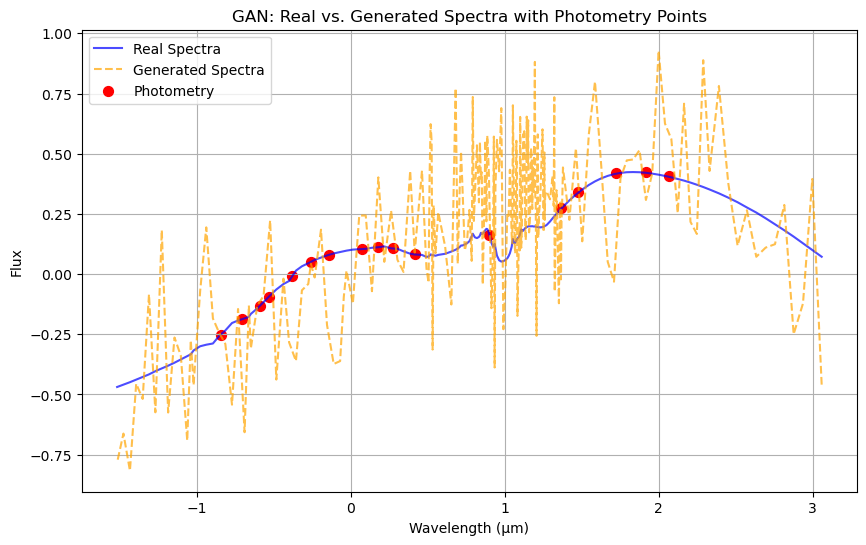

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_model(test_photometry_data, test_spectra_data, photometry_wavelengths, spectra_wavelengths):
    model_gan = PhotometryToSpectraModel(
    photometry_dim=photometry_dim, 
    spectra_dim=spectra_dim, 
    latent_dim=latent_dim, 
    transformer_hidden_dim=transformer_hidden_dim, 
    transformer_nhead=transformer_nhead, 
    transformer_layers=transformer_layers
).to(device)
    model_gan.load_state_dict(torch.load("./gan_model.pth", weights_only=True))
    model_gan.eval()
    
    with torch.no_grad():
        # Generate predictions
        generated_spectra = model_gan.forward_generator(test_photometry_data)
        
        # Calculate metrics
        mse = mean_squared_error(test_spectra_data.cpu(), generated_spectra.cpu())
        mae = mean_absolute_error(test_spectra_data.cpu(), generated_spectra.cpu())
        
        print(f"Test MSE: {mse}")
        print(f"Test MAE: {mae}")

    # Visualize the comparison for a few samples
    n_samples = 2  # Number of samples to visualize
    # fig, axes = plt.subplots(n_samples, 1, figsize=(10, 2 * 3))
    
    # for i in range(n_samples):
    real_sample = test_spectra_data[4,:].cpu().numpy()
    photometry_data = test_photometry_data[4,:].cpu().numpy()
    generated_sample = generated_spectra[4,:].cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.plot(spectra_wavelengths, real_sample, label='Real Spectra', color='blue', alpha=0.7)
    
    # Plotting the generated spectra
    plt.plot(spectra_wavelengths, generated_sample, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
    
    # Plotting the photometry points
    plt.scatter(photometry_wavelengths, photometry_data, label='Photometry', color='red', s=50)
    # axes.set_title(f"Sample {i+1}")
    # Add labels and legend
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux')
    plt.title('GAN: Real vs. Generated Spectra with Photometry Points')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# After training, evaluate on a test dataset
df_wavelengths = pd.read_csv("../data/interpolated_spectra.csv").T
df_wavelengths.reset_index(inplace=True)
df_wavelengths.columns = range(len(df_wavelengths.columns))
df_wavelengths = df_wavelengths.values.astype(np.float64)
df_wavelengths_scaled = df_wavelengths / np.max(df_wavelengths)
data_wavelengths_photo = df_wavelengths[:, 0]  # Shape: [17]
fluxes_ph = data_ph[:, 0:]  # Transpose to get shape [10000, 17]
# Spectra
df_wavelengths_spectra = pd.read_csv("../data/spectra.csv").T
df_wavelengths_spectra.reset_index(inplace=True)
df_wavelengths_spectra.columns = range(len(df_wavelengths_spectra.columns))
df_wavelengths_spectra = df_wavelengths_spectra.values.astype(np.float64)
df_wavelengths_scaled_spectra = df_wavelengths_spectra / np.max(df_wavelengths_spectra)
data_wavelengths_spectra = df_wavelengths_spectra[:, 0]  # Shape: [17]

photometry_wavelengths = data_wavelengths_photo   # 17 photometry wavelength points
spectra_wavelengths = data_wavelengths_spectra   # 17 photometry wavelength points
test_photometry_data = torch.tensor(data_scaled_ph.T, dtype=torch.float32).to(device)  # Reshape if necessary
test_spectra_data = torch.tensor(data_scaled_sp.T, dtype=torch.float32).to(device)
print(test_photometry_data.shape, test_spectra_data.shape)
# print(test_spectra_data[:,:],spectra_wavelengths[0,:])
evaluate_model(test_photometry_data, test_spectra_data, photometry_wavelengths, spectra_wavelengths)

